### Importing Libraries

---









In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import mean_squared_log_error

### Dataset

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

periode  cash_in_echannel  cash_out_echannel  cash_in_kantor  \
0  2019-07-31      7.303000e+08      -1.304400e+09    1.436722e+11   
1  2019-08-01      7.322000e+08      -8.321500e+08    3.144131e+11   
2  2019-08-02      1.169800e+09      -6.214000e+08    1.251294e+09   
3  2019-08-03      9.134500e+08      -4.240500e+08    0.000000e+00   
4  2019-08-04      7.752500e+08      -7.779500e+08    9.883331e+10   

   cash_out_kantor  cr_ketetapan_total_bkn_sum          giro      deposito  \
0    -1.106104e+11                         3.0  9.867358e+11  8.048153e+11   
1    -6.710987e+10                         3.0  8.962459e+11  8.125611e+11   
2    -1.142332e+09                         3.0  9.059714e+11  8.127225e+11   
3     0.000000e+00                         3.0  9.057127e+11  8.127253e+11   
4    -8.729274e+10                         3.0  9.788347e+11  8.124711e+11   

   kewajiban_lain      tabungan  rata_dpk_mingguan    kas_kantor  kas_echannel  
0    1.419685e+10  7.072647e+11       3.135744e+11  1.928940e+09  2.939100e+09  
1    1.234062e+10  7.011995e+11       3.135744e+11  2.492322e+11  2.839150e+09  
2    1.182022e+10  6.922787e+11       3.135744e+11  2.493411e+11  3.387550e+09  
3    1.199640e+10  6.867224e+11       3.135744e+11  2.493411e+11  3.876950e+09  
4    1.232962e+10  6.813438e+11       3.135744e+11  2.608817e+11  3.874250e+09

In [4]:
df_train.shape

(425, 13)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   periode                     425 non-null    object 
 1   cash_in_echannel            425 non-null    float64
 2   cash_out_echannel           425 non-null    float64
 3   cash_in_kantor              425 non-null    float64
 4   cash_out_kantor             425 non-null    float64
 5   cr_ketetapan_total_bkn_sum  425 non-null    float64
 6   giro                        425 non-null    float64
 7   deposito                    425 non-null    float64
 8   kewajiban_lain              425 non-null    float64
 9   tabungan                    425 non-null    float64
 10  rata_dpk_mingguan           425 non-null    float64
 11  kas_kantor                  425 non-null    float64
 12  kas_echannel                425 non-null    float64
dtypes: float64(12), object(1)
memory us

Kolom periode bertipe object, sedangkan seharusnya tipe dari kolom periode adalah datetime. Maka, tipe data kolom periode harus diubah dari object ke datetime.


In [6]:
df_train['periode'] = pd.to_datetime(df_train['periode'])

In [7]:
df_train_copy = df_train.copy()

In [8]:
dates = pd.date_range('2019-07-31', '2020-09-30')
df_train_copy = df_train_copy.set_index('periode')
df_train_copy = df_train_copy.reindex(dates , fill_value = 0)
df_train_copy = df_train_copy.reset_index().rename(columns = {'index' : 'periode'})
df_train_copy[df_train_copy['cash_in_echannel'] == 0]

periode  cash_in_echannel  cash_out_echannel  cash_in_kantor  \
17  2019-08-17               0.0                0.0             0.0   
325 2020-06-20               0.0                0.0             0.0   
329 2020-06-24               0.0                0.0             0.0   
393 2020-08-27               0.0                0.0             0.0   

     cash_out_kantor  cr_ketetapan_total_bkn_sum          giro      deposito  \
17               0.0                         3.0  9.937675e+11  8.162532e+11   
325              0.0                         0.0  0.000000e+00  0.000000e+00   
329              0.0                         0.0  0.000000e+00  0.000000e+00   
393              0.0                         0.0  0.000000e+00  0.000000e+00   

     kewajiban_lain      tabungan  rata_dpk_mingguan    kas_kantor  \
17     1.122372e+10  6.297599e+11       3.121542e+11  5.278389e+11   
325    0.000000e+00  0.000000e+00       0.000000e+00  0.000000e+00   
329    0.000000e+00  0.000000e+00       0.000000e+00  0.000000e+00   
393    0.000000e+00  0.000000e+00       0.000000e+00  0.000000e+00   

     kas_echannel  
17   3.902150e+09  
325  0.000000e+00  
329  0.000000e+00  
393  0.000000e+00

Dari output di atas terlihat bahwa ada data di suatu periode yang hilang yaitu pada tanggal **'2020-06-20'**, **'2020-06-24'**, dan **'2020-08-27'**

In [9]:
for i in list(df_train_copy.columns[5:]):
  df_train_copy[i].replace(0, np.nan, inplace = True)
for i in [325, 329, 393]:
  for j in range(1,5):
    df_train_copy.iloc[i,j] = np.nan
df_train_copy[df_train_copy['giro'].isnull() == True]

periode  cash_in_echannel  cash_out_echannel  cash_in_kantor  \
325 2020-06-20               NaN                NaN             NaN   
329 2020-06-24               NaN                NaN             NaN   
393 2020-08-27               NaN                NaN             NaN   

     cash_out_kantor  cr_ketetapan_total_bkn_sum  giro  deposito  \
325              NaN                         NaN   NaN       NaN   
329              NaN                         NaN   NaN       NaN   
393              NaN                         NaN   NaN       NaN   

     kewajiban_lain  tabungan  rata_dpk_mingguan  kas_kantor  kas_echannel  
325             NaN       NaN                NaN         NaN           NaN  
329             NaN       NaN                NaN         NaN           NaN  
393             NaN       NaN                NaN         NaN           NaN

Impute data di periode yang hilang dengan menggunakan nilai sebelumnya

In [10]:
df_train_copy.fillna(method = 'bfill', inplace = True)

### Data Preprocessing

Check for missing values

In [12]:
df_train_copy.isnull().sum()

periode                       0
cash_in_echannel              0
cash_out_echannel             0
cash_in_kantor                0
cash_out_kantor               0
cr_ketetapan_total_bkn_sum    0
giro                          0
deposito                      0
kewajiban_lain                0
tabungan                      0
rata_dpk_mingguan             0
kas_kantor                    0
kas_echannel                  0
dtype: int64

Tampak bahwa tidak ada nilai yang missing dari semua kolom

**Handling Outliers**

In [13]:
#Stastika deskriptif sebelum handling outlier
df_train_copy.describe()

cash_in_echannel  cash_out_echannel  cash_in_kantor  cash_out_kantor  \
count      4.280000e+02       4.280000e+02    4.280000e+02     4.280000e+02   
mean       7.044368e+08      -6.991727e+08    8.969531e+10    -6.284690e+10   
std        3.416556e+08       3.728429e+08    9.242002e+10     5.223760e+10   
min        0.000000e+00      -2.670100e+09    0.000000e+00    -3.447494e+11   
25%        4.748250e+08      -8.324250e+08    0.000000e+00    -9.590467e+10   
50%        6.364500e+08      -6.349750e+08    7.966337e+10    -6.711632e+10   
75%        8.582250e+08      -4.794375e+08    1.265402e+11     0.000000e+00   
max        3.744400e+09       0.000000e+00    6.569255e+11     0.000000e+00   

       cr_ketetapan_total_bkn_sum          giro      deposito  kewajiban_lain  \
count                       428.0  4.280000e+02  4.280000e+02    4.280000e+02   
mean                          3.0  8.817680e+11  9.005016e+11    1.376900e+10   
std                           0.0  3.876365e+11  1.909538e+11    3.404062e+09   
min                           3.0  3.820936e+11  7.293214e+11    1.008030e+10   
25%                           3.0  6.131446e+11  8.079506e+11    1.172173e+10   
50%                           3.0  8.189379e+11  8.560448e+11    1.280006e+10   
75%                           3.0  1.028097e+12  9.102549e+11    1.524670e+10   
max                           3.0  4.678342e+12  3.464395e+12    4.759059e+10   

           tabungan  rata_dpk_mingguan    kas_kantor  kas_echannel  
count  4.280000e+02       4.280000e+02  4.280000e+02  4.280000e+02  
mean   6.783979e+11       3.090219e+11  5.773013e+12  3.753462e+09  
std    1.090277e+11       3.755760e+10  3.254091e+12  1.026663e+09  
min    6.170567e+11       2.544115e+11  1.928940e+09  1.834650e+09  
25%    6.435357e+11       2.801590e+11  2.993679e+12  3.090275e+09  
50%    6.674770e+11       3.053965e+11  5.514835e+12  3.532900e+09  
75%    6.964613e+11       3.306770e+11  8.491308e+12  4.088550e+09  
max    2.794601e+12       4.516209e+11  1.140874e+13  9.070650e+09

Dari output di atas terlihat bahwa kolom cr_ketetapan_total_bkn_sum memiliki nilai yang konstan

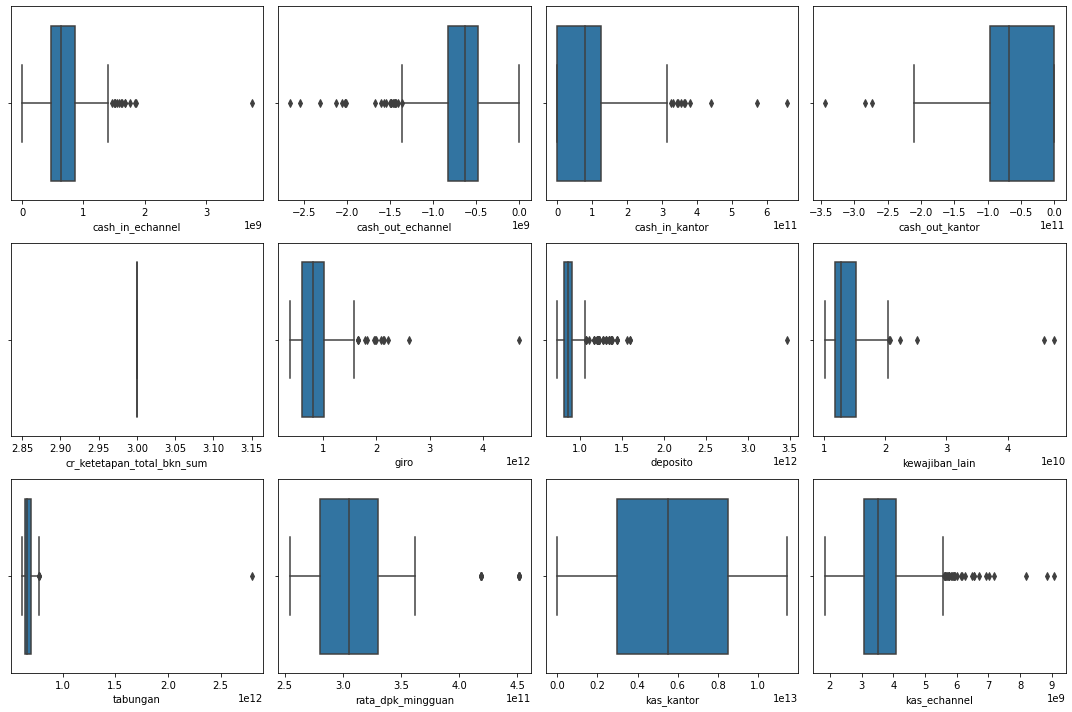

In [14]:
plt.figure(figsize = (15,10))
for i, col in enumerate(df_train_copy.iloc[: , 1:].columns.values):
  plt.subplot(3,4,i+1)
  sns.boxplot(x = col, data = df_train_copy)
  plt.tight_layout()
plt.show()

Handling outlier dengan impute nilai maksimum dan minimum.

In [16]:
#Variabel yang memiliki outliers
outlier = list(df_train_copy.columns)[5:]
outlier.remove('cr_ketetapan_total_bkn_sum')
outlier.remove('kas_kantor')
outlier

['giro',
 'deposito',
 'kewajiban_lain',
 'tabungan',
 'rata_dpk_mingguan',
 'kas_echannel']

In [17]:
Q1 = df_train_copy[outlier].quantile(0.25)
Q3 = df_train_copy[outlier].quantile(0.75)
IQR = Q3 - Q1

maximum = Q3 + (1.5*IQR)
print('Nilai maksimum dari masing-masing variabel adalah ')
print(maximum)
minimum = Q1 - (1.5*IQR)
print('Nilai minimum dari masing-masing variabel adalah ')
print(minimum)

more_than = (df_train_copy[outlier] > maximum)
lower_than = (df_train_copy[outlier] < minimum)
df_train_copy[outlier] = df_train_copy[outlier].mask(more_than, maximum, axis = 1)
df_train_copy[outlier] = df_train_copy[outlier].mask(lower_than, minimum, axis = 1)

print('\nPersebaran data setelah ditangani Outlier: ')
print(df_train_copy[outlier].describe())

Nilai maksimum dari masing-masing variabel adalah 
giro                 1.650525e+12
deposito             1.063711e+12
kewajiban_lain       2.053417e+10
tabungan             7.758497e+11
rata_dpk_mingguan    4.064541e+11
kas_echannel         5.585962e+09
dtype: float64
Nilai minimum dari masing-masing variabel adalah 
giro                -9.283338e+09
deposito             6.544943e+11
kewajiban_lain       6.434263e+09
tabungan             5.641473e+11
rata_dpk_mingguan    2.043819e+11
kas_echannel         1.592862e+09
dtype: float64

Persebaran data setelah ditangani Outlier: 
               giro      deposito  kewajiban_lain      tabungan  \
count  4.280000e+02  4.280000e+02    4.280000e+02  4.280000e+02   
mean   8.645755e+11  8.741834e+11    1.363026e+10  6.736754e+11   
std    3.107593e+11  8.682794e+10    2.529958e+09  3.738912e+10   
min    3.820936e+11  7.293214e+11    1.008030e+10  6.170567e+11   
25%    6.131446e+11  8.079506e+11    1.172173e+10  6.435357e+11   
50%    8.18937

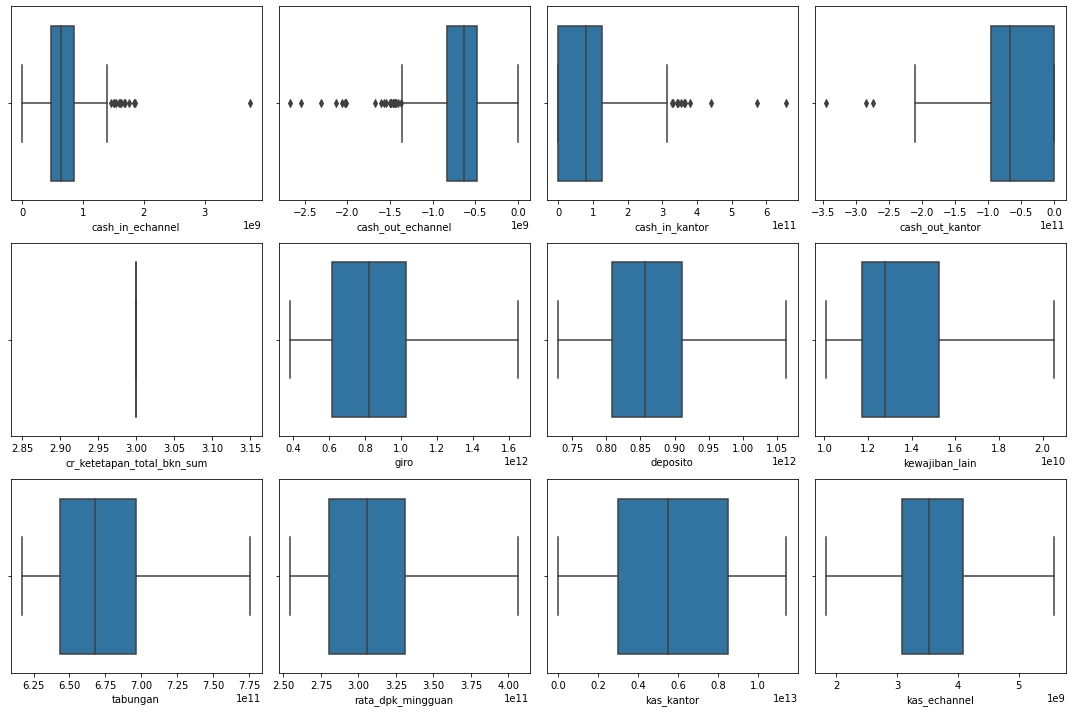

In [18]:
plt.figure(figsize = (15,10))
for i, col in enumerate(df_train_copy.iloc[: , 1:].columns.values):
  plt.subplot(3,4,i+1)
  sns.boxplot(x = col, data = df_train_copy)
  plt.tight_layout()
plt.show()

### Exploratory Data Analysis

**Data Description**

*cash_in_echannel*: Total Kas Masuk pada kas eChannel (ATM dan CRM)

*cash_out_echannel*: Total Kas keluar pada kas eChannel (ATM dan CRM)

*cash_in_kantor*: Total kas masuk pada kas kantor

*cash_out_kantor* :Total kas keluar pada kas kantor

*cr_ketetapan_total_bkn_sum* :Maksimum cash ratio yang dii tetapkan kantor pusat

*giro*:Total simpanan giro

*deposito* : Total simpanan deposito

*kewajiban_lain*: "Simpanan selain giro tabungan dan deposito ,salah satunya adalah surat berharga yang diterbitkan"

*tabungan* : Total simpanan tabungan

*rata_dpk_mingguan* : rata - rata saldo DPK mingguan

*kas_kantor* : Total Dari kas kantor

*kas_echannel* : Total dari kas eChannel

In [19]:
df_train_copy['periode'].describe()

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                     428
unique                    428
top       2020-02-11 00:00:00
freq                        1
first     2019-07-31 00:00:00
last      2020-09-30 00:00:00
Name: periode, dtype: object

**Line Graph**



1.   Cash in echannel



In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(df_train_copy.periode), y = list(df_train_copy.cash_in_echannel)))
fig.update_layout(title_text="Cash in echannel")
fig.update_xaxes(title_text = "Periode")
fig.update_yaxes(title_text = "cash in")
fig.show()

Beberapa informasi yang dapat diperoleh dari grafik di atas yaitu:

*   Cash in pada hari sabtu mostly menurun 
*   Cash in naik pada awal bulan dan mendekati akhir bulan
* Rentang liburan lebaran cash in echannel menurun
* libur tahun baru cash in echannel menurun

2. Cash out echannel

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(df_train_copy.periode), y = list(df_train_copy.cash_out_echannel)))
fig.update_layout(title_text="Cash out echannel")
fig.update_xaxes(title_text = "Periode")
fig.update_yaxes(title_text = "cash out")
fig.show()

Beberapa informasi yang dapat diperoleh dari grafik di atas yaitu:


*   Setiap hari sabtu pengeluaran tidak terlalu besar
*   Rata-rata pada hari minggu, pengeluaran cukup besar
* 26 Dec cash out echannel melonjak -> dugaan dikarenakan christmas holiday
* 17 Agustus cukup melonjak -> hari kemerdekaan Indonesia

3. Kas echannel

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(df_train_copy.periode), y = list(df_train_copy.kas_echannel)))
fig.update_layout(title_text="Kas echannel")
fig.update_xaxes(title_text = "Periode")
fig.update_yaxes(title_text = "Kas echannel")
fig.show()

Selaras dengan hasil dari cash in, bahwa pada awal bulan kas echannel terdapat kenaikan

4. Cash in kantor

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(df_train_copy.periode), y = list(df_train_copy.cash_in_kantor)))
fig.update_layout(title_text="cash in kantor")
fig.update_xaxes(title_text = "Periode")
fig.update_yaxes(title_text = "cash in kantor")
fig.show()

Beberapa informasi yang dapat ditarik dari grafik di atas adalah:


*   Cash in kantor menurun saat hari Jumat dan Sabtu
*   Dalam satu minggu, besaran cash in kantor yang paling tinggi di hari kamis
* 31 December tidak ada cash in kantor -> akhir tahun
* 24 March tidak ada cash in kantor -> 25 March merupakan hari nyepi
* 6 May tidak ada cash in kantor -> 7 May hari raya waisak
* 24 May tidak ada cash in kantor -> 25 May hari libur lebaran
* 29 Juli cash in kantor tinggi -> H-2 sebelum idul adha

5. Cash out kantor

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(df_train_copy.periode), y = list(df_train_copy.cash_out_kantor)))
fig.update_layout(title_text="cash out kantor")
fig.update_xaxes(title_text = "Periode")
fig.update_yaxes(title_text = "cash out kantor")
fig.show()

Beberapa informasi yang dapat ditarik dari grafik di atas adalah:
* Tidak ada cash out kantor di hari jumat dan sabtu
* Cash out kantor tinggi pada hari kamis
* 6 & 20 May tidak ada cash out kantor, dugaan terbesar dikarenakan mendekati libur lebaran.
* 31 december tidak ada cash out kantor (akhir tahun)
* 24 Maret tidak ada cash out kantor
* 23 agustus 2020 (long weekend) -> cash out kantor tinggi
* 29 Juli 2020 cash out kantor tinggi -> mendekati hari raya idul adha
* 25 May cash out kantor tinggi (hari lebaran)

Jadi, pada hari cash in kantor tinggi begitupun cash out kantor juga tinggi, kemudian pada hari jumat dan sabtu tidak ada cash in kantor dan cash out kantor

6. Kas kantor

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(df_train_copy.periode), y = list(df_train_copy.kas_kantor)))
fig.update_layout(title_text="kas kantor")
fig.update_xaxes(title_text = "Periode")
fig.update_yaxes(title_text = "kas kantor")
fig.show()

Dari grafik di atas, diperoleh dugaan bahwa efek akhir tahun dan lebaran memengaruhi besarnya kas kantor

7. Variabel lainnya

In [26]:
import plotly.express as px
def line_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[6:-2]:
    fig.add_scatter(x = df['periode'], y = df[i], name = i)
  fig.show()

In [27]:
line_plot(df_train_copy, '')

Beberapa informasi yang dapat diperoleh dari grafik di atas yaitu:
* Terdapat kenaikan kewajiban lain di pertengahan bulan (sekitar tanggal 20)
* terdapat puncak di variabel rata_dpk_mingguan pada rentang tanggal 7 s.d. 14 di setiap bulannya
* Nilai giro tinggi pada akhir bulan (di tanggal 27 ke atas) di setiap bulannya
* Nilai tabungan tinggi di akhir bulan. Kemungkinan orang menabung setelah menerima uang gajian bulanan.
* Nilai deposito naik mostly di waktu weekend (jumat, sabtu, minggu)

**Stationary**

In [28]:
from statsmodels.tsa.stattools import adfuller
def stationary_test(df):
  rolmean = df.rolling(3).mean()
  rolstd = df.rolling(3).std()
  #plot
  #plt.figure(figsize = (15,10))
  #plt.plot(df, color = 'blue', label = 'original')
  #plt.plot(rolmean, color = 'red', label = 'Rolling mean')
  #plt.plot(rolstd, color = 'black', label = 'Rolling std')
  #plt.legend(loc = 'best')
  #plt.title('Rolling mean and standard deviation')
  #plt.show()
  #adf test
  print('Result of adf test:')
  df_test = adfuller(df, autolag = 'AIC')
  df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#lags-used', 'Number of observation used'])
  for  key,value in df_test[4].items():
    df_output['critical value (%s)'%key] = value
  print(df_output)    

1. Stationary test for cash in echannel

In [29]:
stationary_test(df_train_copy['cash_in_echannel'])

Result of adf test:
Test Statistic                 -2.703499
p-value                         0.073435
#lags-used                     14.000000
Number of observation used    413.000000
critical value (1%)            -3.446283
critical value (5%)            -2.868564
critical value (10%)           -2.570511
dtype: float64


2. Stationary test for cash out echannel

In [31]:
stationary_test(df_train_copy['cash_out_echannel'])

Result of adf test:
Test Statistic                 -5.356597
p-value                         0.000004
#lags-used                      6.000000
Number of observation used    421.000000
critical value (1%)            -3.445979
critical value (5%)            -2.868430
critical value (10%)           -2.570440
dtype: float64


3. Stationary test for cash in kantor

In [32]:
stationary_test(df_train_copy['cash_in_kantor'])

Result of adf test:
Test Statistic               -6.023482e+00
p-value                       1.474690e-07
#lags-used                    1.800000e+01
Number of observation used    4.090000e+02
critical value (1%)          -3.446440e+00
critical value (5%)          -2.868633e+00
critical value (10%)         -2.570548e+00
dtype: float64


4. Stationary test for cash out kantor

In [33]:
stationary_test(df_train_copy['cash_out_kantor'])

Result of adf test:
Test Statistic                 -4.396147
p-value                         0.000302
#lags-used                     13.000000
Number of observation used    414.000000
critical value (1%)            -3.446244
critical value (5%)            -2.868547
critical value (10%)           -2.570502
dtype: float64


Kesimpulan yang dapat ditarik dari stationary test adalah semua variabel target kecuali cash in echannel pada data ini sudah stasioner dikarenakan nilai `p-value` dari keempat variabel $< 0,05$

**Correlation between variables**

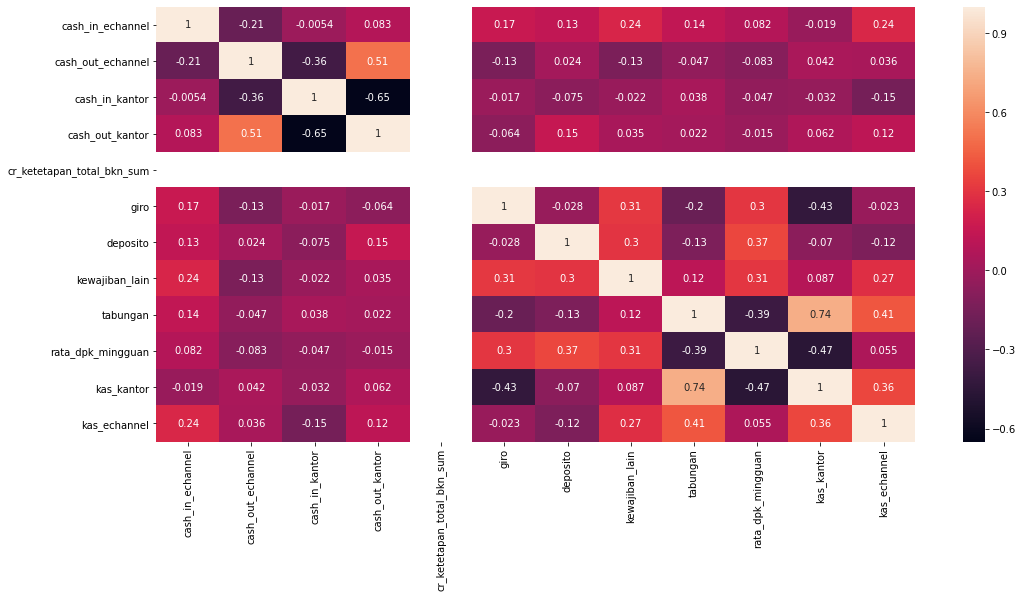

In [34]:
plt.figure(figsize = (17,8))
sns.heatmap(df_train_copy.corr(), annot = True)

Dari *heatmap* di atas, dapat ditarik beberapa *insight* yaitu:
1. Korelasi tertinggi yaitu antara variabel tabungan dan kas kantor yang memiliki nilai korelasi sebesar $0,74$. 
2. Korelasi antara cash out echannel dan cash out kantor cukup tinggi yaitu sebesar $0,51$, hal ini ddapat terjadi karena seperti yang terlihat pada grafik terdapat kesamaan pola yaitu pengeluaran sedikit/tidak ada di hari sabtu
3. Variabel lain di luar variabel target (giro, deposito, tabungan, kewajiban lain, rata dpk mingguan) memiliki nilai korelasi yang kecil dengan variabel target.

### Prophet Modeling

#### Cash in echannel

`Modeling`

In [35]:
cash_in_echannel = df_train_copy[['periode', 'cash_in_echannel']].rename(columns = {'periode' : 'ds', 'cash_in_echannel' : 'y'})
cash_in_echannel.head()

ds             y
0 2019-07-31  7.303000e+08
1 2019-08-01  7.322000e+08
2 2019-08-02  1.169800e+09
3 2019-08-03  9.134500e+08
4 2019-08-04  7.752500e+08

In [36]:
cash_in_echannel_copy = cash_in_echannel.copy()
cash_in_echannel_copy['y'] = cash_in_echannel_copy['y'].replace(0,1)
cash_in_echannel_copy['y'] = cash_in_echannel_copy['y'].apply(np.log)

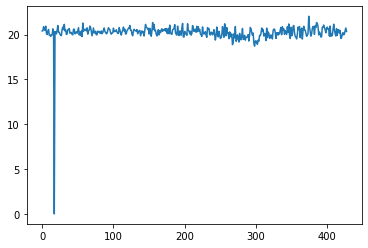

In [37]:
plt.plot(cash_in_echannel_copy['y'])

In [38]:
stationary_test(cash_in_echannel_copy['y'])

Result of adf test:
Test Statistic                -19.541652
p-value                         0.000000
#lags-used                      0.000000
Number of observation used    427.000000
critical value (1%)            -3.445758
critical value (5%)            -2.868333
critical value (10%)           -2.570388
dtype: float64


Setelah dilakukan log transformation, variabel cash in echannel menjadi stasioner

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in echannel')

<Figure size 1224x576 with 0 Axes>

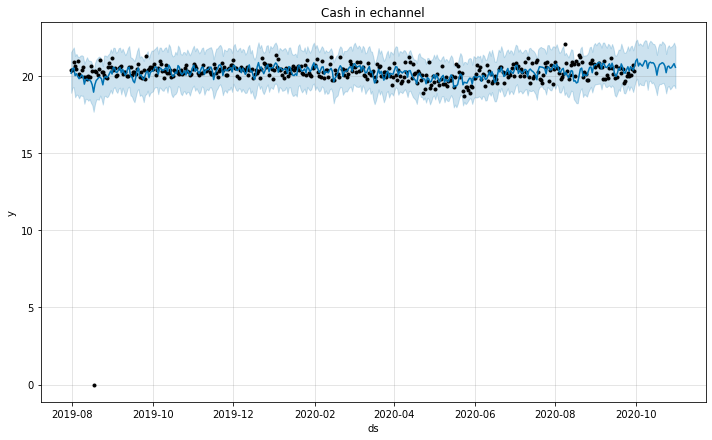

In [39]:
model_cash_in_echannel = Prophet(yearly_seasonality= True)
model_cash_in_echannel.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_in_echannel.fit(cash_in_echannel_copy)

future = model_cash_in_echannel.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_in_echannel.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_in_echannel.plot(forecast)
plt.title('Cash in echannel')

`Evaluation`

In [40]:
pd.set_option('display.max_rows', None)

In [41]:
actual_predict_cash_in = cash_in_echannel.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in['prediction'] = forecast['yhat'].apply(np.exp)
actual_predict_cash_in['error (MAE)'] = np.abs(actual_predict_cash_in['actual'] - actual_predict_cash_in['prediction'])
actual_predict_cash_in['MAPE'] = (np.abs(actual_predict_cash_in['actual'] - actual_predict_cash_in['prediction'])*100)/actual_predict_cash_in['actual']
actual_predict_cash_in.head()

ds        actual    prediction   error (MAE)       MAPE
0 2019-07-31  7.303000e+08  5.769770e+08  1.533230e+08  20.994527
1 2019-08-01  7.322000e+08  7.708807e+08  3.868069e+07   5.282803
2 2019-08-02  1.169800e+09  8.217867e+08  3.480133e+08  29.749815
3 2019-08-03  9.134500e+08  4.936146e+08  4.198354e+08  45.961506
4 2019-08-04  7.752500e+08  5.612288e+08  2.140212e+08  27.606729

In [42]:
print('Error (Mean Absolute Error): ',actual_predict_cash_in['error (MAE)'].mean())

Error (Mean Absolute Error):  240124929.50657743


In [43]:
mean_squared_log_error(y_true = actual_predict_cash_in['actual'],y_pred = actual_predict_cash_in['prediction']) ** 0.5

1.0228727601872536

Add holiday effect

In [44]:
holiday_1 = pd.DataFrame({
    'holiday' : ['New Year Day', 'Chinese New Year', 'Nyepi', 'Waisak', 'Eid al-fitr', 'Eid Adha', 'Christmas', 'Independence day', 'Independence day'],
    'ds' : pd.to_datetime(['2019-12-31', '2020-01-25', '2020-03-25', '2020-05-07', '2020-05-25', '2020-07-31', '2019-12-25', '2020-08-17', '2019-08-17']),
    'lower_window' : -1,
    'upper_window' : 0
})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in echannel')

<Figure size 1224x576 with 0 Axes>

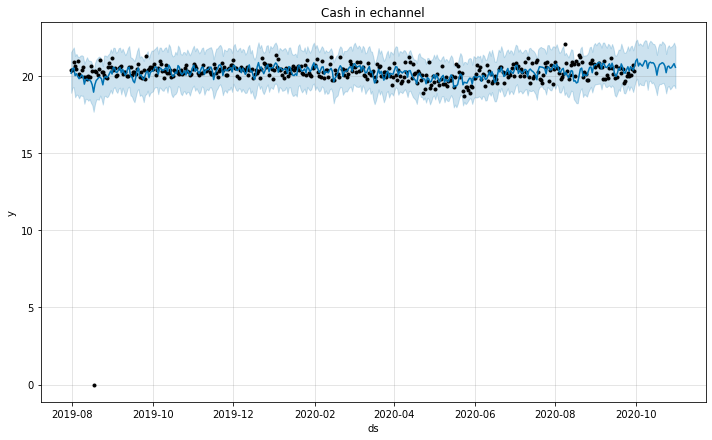

In [45]:
model_cash_in_echannel_holiday = Prophet(yearly_seasonality= True, holidays =holiday_1)
model_cash_in_echannel_holiday.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_in_echannel_holiday.fit(cash_in_echannel_copy)

future_holiday = model_cash_in_echannel_holiday.make_future_dataframe(periods = 31, freq = 'D')
forecast_holiday = model_cash_in_echannel.predict(future_holiday)

plt.figure(figsize = (17,8))
a = model_cash_in_echannel_holiday.plot(forecast)
plt.title('Cash in echannel')

In [46]:
actual_predict_cash_in = cash_in_echannel.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in['prediction'] = forecast_holiday['yhat'].apply(np.exp)
actual_predict_cash_in['error (MAE)'] = np.abs(actual_predict_cash_in['actual'] - actual_predict_cash_in['prediction'])
actual_predict_cash_in['MAPE'] = (np.abs(actual_predict_cash_in['actual'] - actual_predict_cash_in['prediction'])*100)/actual_predict_cash_in['actual']
actual_predict_cash_in.head()

ds        actual    prediction   error (MAE)       MAPE
0 2019-07-31  7.303000e+08  5.769770e+08  1.533230e+08  20.994527
1 2019-08-01  7.322000e+08  7.708807e+08  3.868069e+07   5.282803
2 2019-08-02  1.169800e+09  8.217867e+08  3.480133e+08  29.749815
3 2019-08-03  9.134500e+08  4.936146e+08  4.198354e+08  45.961506
4 2019-08-04  7.752500e+08  5.612288e+08  2.140212e+08  27.606729

In [47]:
mean_squared_log_error(y_true = actual_predict_cash_in['actual'],y_pred = actual_predict_cash_in['prediction']) ** 0.5

1.0228727601872536

Hyperparameter tunning

In [48]:
from tqdm import tqdm
import itertools

param_grid = {
    'seasonality_mode' : ['multiplicative', 'additive'],
    'changepoint_prior_scale' : [0.001, 0.005, 0.1, 0.2, 0.25, 0.5],
    'changepoint_range' : [0.8, 0.85, 0.9, 0.95]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

for params in tqdm(all_params):
  model = Prophet(**params, yearly_seasonality= True, holidays =holiday_1)
  model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
  model.fit(cash_in_echannel_copy)
  future_tunning = model.make_future_dataframe(periods = 31, freq = 'D')
  forecast_tunning = model.predict(future_tunning)

  rmlse = mean_squared_log_error(y_true=np.abs(cash_in_echannel['y']), y_pred=forecast_tunning['yhat'].head(428).apply(np.exp)) ** 0.5
  rmsles.append(rmlse)

 75%|█████████████████████████████████████████████████████████████▌                    | 36/48 [03:51<01:16,  6.38s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [05:16<00:00,  6.59s/it]


In [49]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by = 'rmsle').head(10)

seasonality_mode  changepoint_prior_scale  changepoint_range     rmsle
46         additive                     0.50               0.90  1.016357
47         additive                     0.50               0.95  1.016400
22   multiplicative                     0.50               0.90  1.017306
23   multiplicative                     0.50               0.95  1.018292
42         additive                     0.25               0.90  1.018755
45         additive                     0.50               0.85  1.019482
44         additive                     0.50               0.80  1.019570
43         additive                     0.25               0.95  1.019879
18   multiplicative                     0.25               0.90  1.020016
38         additive                     0.20               0.90  1.020213

In [50]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.5,
 'changepoint_range': 0.9}

Best model for cash in echannel

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in echannel')

<Figure size 1224x576 with 0 Axes>

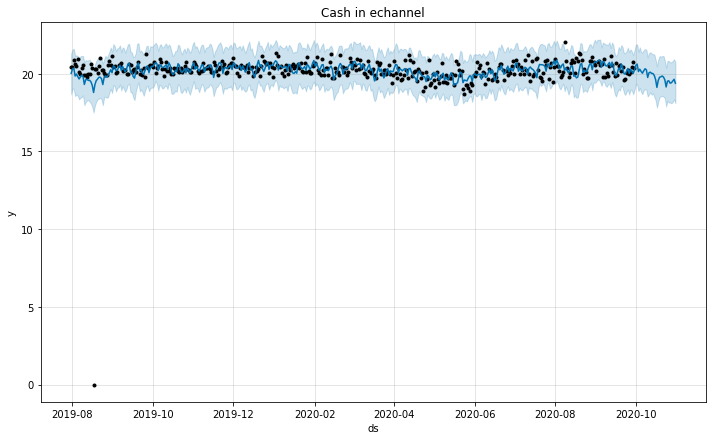

In [51]:
model_cash_in_echannel_best = Prophet(**best_params, yearly_seasonality= True, holidays =holiday_1)
model_cash_in_echannel_best.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_in_echannel_best.fit(cash_in_echannel_copy)

future_best = model_cash_in_echannel_best.make_future_dataframe(periods = 31, freq = 'D')
forecast_best = model_cash_in_echannel_best.predict(future_best)

plt.figure(figsize = (17,8))
a = model_cash_in_echannel_best.plot(forecast_best)
plt.title('Cash in echannel')

In [55]:
actual_predict_cash_in = cash_in_echannel.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in['prediction'] = forecast_best['yhat'].apply(np.exp)
actual_predict_cash_in['error (MAE)'] = np.abs(actual_predict_cash_in['actual'] - actual_predict_cash_in['prediction'])
actual_predict_cash_in.head()

ds        actual    prediction   error (MAE)
0 2019-07-31  7.303000e+08  4.974006e+08  2.328994e+08
1 2019-08-01  7.322000e+08  6.582918e+08  7.390819e+07
2 2019-08-02  1.169800e+09  6.990375e+08  4.707625e+08
3 2019-08-03  9.134500e+08  4.191697e+08  4.942803e+08
4 2019-08-04  7.752500e+08  4.775982e+08  2.976518e+08

In [56]:
mean_squared_log_error(y_true = actual_predict_cash_in['actual'],y_pred = actual_predict_cash_in['prediction']) ** 0.5

1.016356639678523

In [57]:
predict_cash_in_echannel = list(forecast_best['yhat'].apply(np.exp).tail(31).values)

#### Cash out echannel

In [58]:
cash_out_echannel = df_train_copy[['periode', 'cash_out_echannel']].rename(columns = {'periode' : 'ds', 'cash_out_echannel' : 'y'})
cash_out_echannel.head()

ds             y
0 2019-07-31 -1.304400e+09
1 2019-08-01 -8.321500e+08
2 2019-08-02 -6.214000e+08
3 2019-08-03 -4.240500e+08
4 2019-08-04 -7.779500e+08

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash out echannel')

<Figure size 1224x576 with 0 Axes>

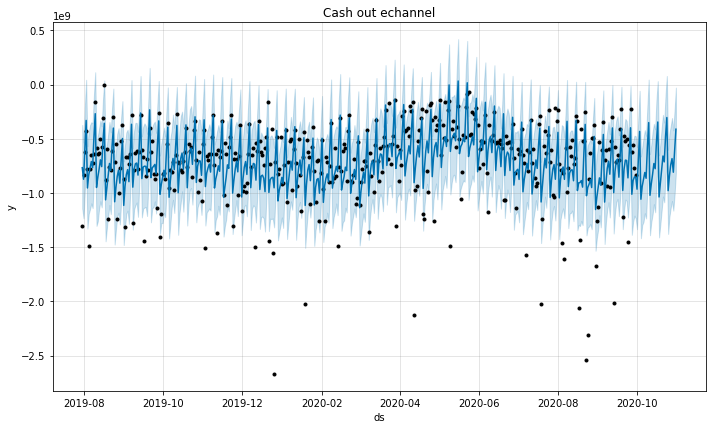

In [59]:
model_cash_out_echannel = Prophet(yearly_seasonality= True, holidays = holiday_1)
model_cash_out_echannel.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_out_echannel.fit(cash_out_echannel)

future = model_cash_out_echannel.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_out_echannel.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_out_echannel.plot(forecast)
plt.title('Cash out echannel')

#b = model_cash_out_echannel.plot_components(forecast)

In [60]:
actual_predict_cash_out = cash_out_echannel.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_out['prediction'] = forecast['yhat']
actual_predict_cash_out['error (MAE)'] = np.abs(actual_predict_cash_out['actual'] - actual_predict_cash_out['prediction'])
actual_predict_cash_out.head()

ds        actual    prediction   error (MAE)
0 2019-07-31 -1.304400e+09 -7.667116e+08  5.376884e+08
1 2019-08-01 -8.321500e+08 -8.730922e+08  4.094219e+07
2 2019-08-02 -6.214000e+08 -5.925163e+08  2.888368e+07
3 2019-08-03 -4.240500e+08 -3.309015e+08  9.314849e+07
4 2019-08-04 -7.779500e+08 -9.538099e+08  1.758599e+08

In [61]:
mean_squared_log_error(y_true = np.abs(actual_predict_cash_out['actual']),y_pred = np.abs(actual_predict_cash_out['prediction'])) ** 0.5

1.047897327945462

Hyperparameter Tunning

In [62]:
from tqdm import tqdm
import itertools

param_grid = {
    'seasonality_mode' : ['multiplicative', 'additive'],
    'changepoint_prior_scale' : [0.001, 0.005, 0.1, 0.2, 0.25, 0.5],
    'changepoint_range' : [0.8, 0.85, 0.9, 0.95]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

for params in tqdm(all_params):
  model = Prophet(**params, yearly_seasonality= True, holidays =holiday_1)
  model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
  model.fit(cash_out_echannel)
  future_tunning = model.make_future_dataframe(periods = 31, freq = 'D')
  forecast_tunning = model.predict(future_tunning)

  rmlse = mean_squared_log_error(y_true=np.abs(cash_out_echannel['y']), y_pred=np.abs(forecast_tunning['yhat'].head(428))) ** 0.5
  rmsles.append(rmlse)

 71%|██████████████████████████████████████████████████████████                        | 34/48 [07:15<01:51,  7.99s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [08:52<00:00, 11.09s/it]


In [63]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by = 'rmsle').head(10)

seasonality_mode  changepoint_prior_scale  changepoint_range     rmsle
7    multiplicative                    0.005               0.95  1.028352
5    multiplicative                    0.005               0.85  1.030639
6    multiplicative                    0.005               0.90  1.031891
4    multiplicative                    0.005               0.80  1.033348
9    multiplicative                    0.100               0.85  1.044459
23   multiplicative                    0.500               0.95  1.045243
46         additive                    0.500               0.90  1.045933
26         additive                    0.001               0.90  1.046155
25         additive                    0.001               0.85  1.046156
24         additive                    0.001               0.80  1.046160

In [64]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'seasonality_mode': 'multiplicative',
 'changepoint_prior_scale': 0.005,
 'changepoint_range': 0.95}

Best Model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash out echannel')

<Figure size 1224x576 with 0 Axes>

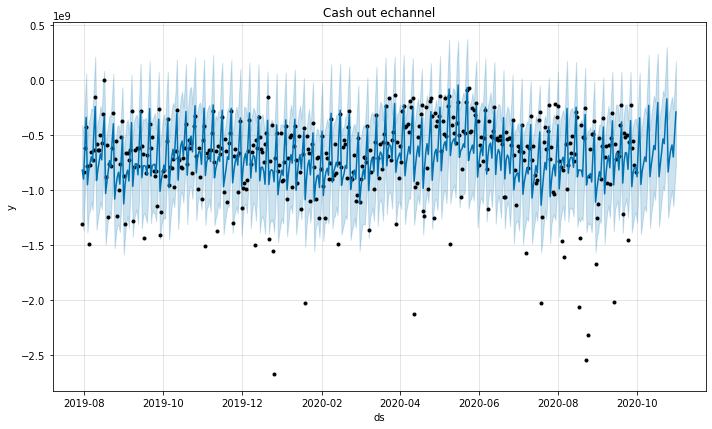

In [65]:
model_cash_out_echannel = Prophet(**best_params, yearly_seasonality= True, holidays = holiday_1)
model_cash_out_echannel.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_out_echannel.fit(cash_out_echannel)

future = model_cash_out_echannel.make_future_dataframe(periods = 31, freq = 'D')
forecast_best_out = model_cash_out_echannel.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_out_echannel.plot(forecast_best_out)
plt.title('Cash out echannel')

#b = model_cash_out_echannel.plot_components(forecast)

In [66]:
actual_predict_cash_out = cash_out_echannel.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_out['prediction'] = forecast_best_out['yhat']
actual_predict_cash_out['error (MAE)'] = np.abs(actual_predict_cash_out['actual'] - actual_predict_cash_out['prediction'])
actual_predict_cash_out.head()

ds        actual    prediction   error (MAE)
0 2019-07-31 -1.304400e+09 -8.188699e+08  4.855301e+08
1 2019-08-01 -8.321500e+08 -9.006943e+08  6.854431e+07
2 2019-08-02 -6.214000e+08 -6.143262e+08  7.073750e+06
3 2019-08-03 -4.240500e+08 -3.411060e+08  8.294397e+07
4 2019-08-04 -7.779500e+08 -9.514635e+08  1.735135e+08

In [67]:
mean_squared_log_error(y_true = np.abs(actual_predict_cash_out['actual']),y_pred = np.abs(actual_predict_cash_out['prediction'])) ** 0.5

1.0283524123425323

In [68]:
predict_cash_out_echannel = list(forecast_best_out['yhat'].tail(31).values)

Prediction Result

In [69]:
init_channel = df_train_copy['kas_echannel'].tail(1).values[0]
lst_channel = []
for i in range(31):
  kas_channel = init_channel + predict_cash_in_echannel[i] + predict_cash_out_echannel[i]
  lst_channel.append(kas_channel)
  init = lst_channel[i]
len(lst_channel)

31

In [70]:
datelist = pd.date_range(start="2020-10-01",end="2020-10-31").tolist()

In [71]:
Kas_channel_prediction = pd.DataFrame({
    'index' : [i for i in range(31,62)],
    'date' : datelist,
    'value' : lst_channel
})
Kas_channel_prediction

index       date         value
0      31 2020-10-01  5.226805e+09
1      32 2020-10-02  5.571371e+09
2      33 2020-10-03  5.484262e+09
3      34 2020-10-04  4.975594e+09
4      35 2020-10-05  5.012560e+09
5      36 2020-10-06  5.013248e+09
6      37 2020-10-07  5.157784e+09
7      38 2020-10-08  5.201824e+09
8      39 2020-10-09  5.439826e+09
9      40 2020-10-10  5.422221e+09
10     41 2020-10-11  4.910077e+09
11     42 2020-10-12  5.035646e+09
12     43 2020-10-13  5.080055e+09
13     44 2020-10-14  5.168814e+09
14     45 2020-10-15  5.072631e+09
15     46 2020-10-16  5.221542e+09
16     47 2020-10-17  5.268468e+09
17     48 2020-10-18  4.708007e+09
18     49 2020-10-19  4.898118e+09
19     50 2020-10-20  5.025772e+09
20     51 2020-10-21  5.155909e+09
21     52 2020-10-22  5.085079e+09
22     53 2020-10-23  5.253392e+09
23     54 2020-10-24  5.307346e+09
24     55 2020-10-25  4.737661e+09
25     56 2020-10-26  4.863252e+09
26     57 2020-10-27  4.903188e+09
27     58 2020-10-28  4.953252e+09
28     59 2020-10-29  4.876627e+09
29     60 2020-10-30  5.117444e+09
30     61 2020-10-31  5.243735e+09

#### Cash in kantor

In [72]:
cash_in_kantor = df_train_copy[['periode', 'cash_in_kantor']].rename(columns = {'periode' : 'ds', 'cash_in_kantor' : 'y'})
cash_in_kantor.head()

ds             y
0 2019-07-31  1.436722e+11
1 2019-08-01  3.144131e+11
2 2019-08-02  1.251294e+09
3 2019-08-03  0.000000e+00
4 2019-08-04  9.883331e+10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in kantor')

<Figure size 1224x576 with 0 Axes>

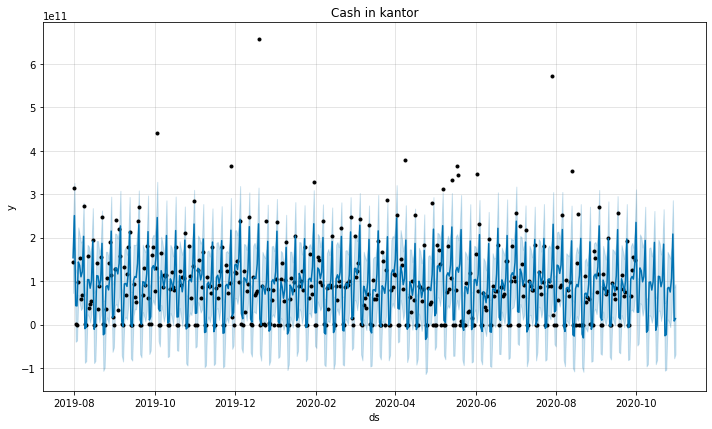

In [73]:
model_cash_in_kantor = Prophet(yearly_seasonality= True)
model_cash_in_kantor.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_in_kantor.fit(cash_in_kantor)

future = model_cash_in_kantor.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_in_kantor.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_in_kantor.plot(forecast)
plt.title('Cash in kantor')

#b = model_cash_in_kantor.plot_components(forecast)

In [74]:
actual_predict_cash_in_kantor = cash_in_kantor.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in_kantor['prediction'] = forecast['yhat']
actual_predict_cash_in_kantor['error (MAE)'] = np.abs(actual_predict_cash_in_kantor['actual'] - actual_predict_cash_in_kantor['prediction'])
actual_predict_cash_in_kantor.head()

ds        actual    prediction   error (MAE)
0 2019-07-31  1.436722e+11  1.537429e+11  1.007071e+10
1 2019-08-01  3.144131e+11  2.507646e+11  6.364853e+10
2 2019-08-02  1.251294e+09  4.343460e+10  4.218331e+10
3 2019-08-03  0.000000e+00  4.281152e+10  4.281152e+10
4 2019-08-04  9.883331e+10  1.438902e+11  4.505693e+10

In [75]:
actual_predict_cash_in_kantor['error (MAE)'].mean()

35816095298.86138

In [76]:
mean_squared_log_error(y_true = np.abs(cash_in_kantor['y']),y_pred = np.abs(forecast['yhat'].head(428))) ** 0.5

11.780476781617276

Holiday effect

In [77]:
holiday = pd.DataFrame({
    'holiday' : ['New Year Day', 'Chinese New Year', 'Nyepi', 'Waisak', 'Eid al-fitr', 'Eid Adha', 'Christmas'],
    'ds' : pd.to_datetime(['2019-12-31', '2020-01-25', '2020-03-25', '2020-05-07', '2020-05-25', '2020-07-31', '2019-12-25']),
    'lower_window' : -1,
    'upper_window' : 0
})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in kantor')

<Figure size 1224x576 with 0 Axes>

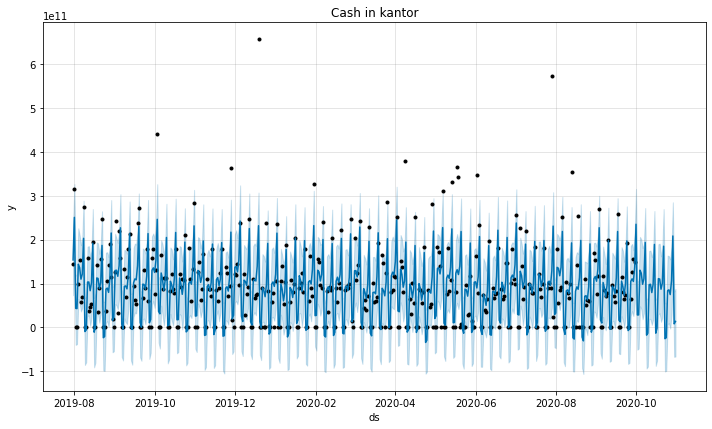

In [78]:
model_cash_in_kantor_holiday = Prophet(yearly_seasonality= True, holidays = holiday)
model_cash_in_kantor_holiday.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_in_kantor_holiday.fit(cash_in_kantor)

future = model_cash_in_kantor_holiday.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_in_kantor_holiday.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_in_kantor_holiday.plot(forecast)
plt.title('Cash in kantor')

#b = model_cash_in_kantor_holiday.plot_components(forecast)

In [79]:
actual_predict_cash_in_kantor_holiday = cash_in_kantor.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in_kantor_holiday['prediction'] = forecast['yhat']
actual_predict_cash_in_kantor_holiday['error (MAE)'] = np.abs(actual_predict_cash_in_kantor_holiday['actual'] - actual_predict_cash_in_kantor_holiday['prediction'])
mean_squared_log_error(y_true = np.abs(actual_predict_cash_in_kantor_holiday['actual']),y_pred = np.abs(actual_predict_cash_in_kantor_holiday['prediction'])) ** 0.5

11.780476781617276

In [80]:
actual_predict_cash_in_kantor_holiday.tail()

ds        actual    prediction   error (MAE)
423 2020-09-26  0.000000e+00 -3.816506e+09  3.816506e+09
424 2020-09-27  6.466720e+10  1.046875e+11  4.002033e+10
425 2020-09-28  1.264345e+11  1.106365e+11  1.579799e+10
426 2020-09-29  1.548627e+11  1.046635e+11  5.019920e+10
427 2020-09-30  1.487817e+11  1.375969e+11  1.118487e+10

In [ ]:
#forecast[['ds','yhat']].tail(31)

In [81]:
mean_squared_log_error(y_true = np.abs(actual_predict_cash_in_kantor_holiday['actual']),y_pred = np.abs(actual_predict_cash_in_kantor_holiday['prediction'])) ** 0.5

11.780476781617276

Log transformation

In [82]:
log_cash_in_kantor = cash_in_kantor.copy()

In [83]:
log_cash_in_kantor['y'] = log_cash_in_kantor['y'].replace(0, 1)

In [84]:
log_cash_in_kantor['y'] = log_cash_in_kantor['y'].apply(np.log)
log_cash_in_kantor.head()

ds          y
0 2019-07-31  25.690800
1 2019-08-01  26.473974
2 2019-08-02  20.947444
3 2019-08-03   0.000000
4 2019-08-04  25.316701

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in kantor')

<Figure size 1224x576 with 0 Axes>

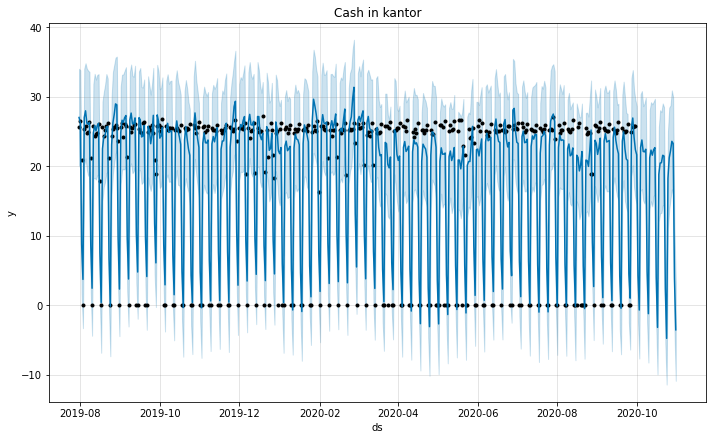

In [88]:
model_cash_in_kantor = Prophet(yearly_seasonality= True)
model_cash_in_kantor.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
#model_cash_in_kantor.add_country_holidays(country_name = 'ID')
model_cash_in_kantor.fit(log_cash_in_kantor)

future = model_cash_in_kantor.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_in_kantor.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_in_kantor.plot(forecast)
plt.title('Cash in kantor')

#b = model_cash_in_kantor.plot_components(forecast)

In [89]:
actual_predict_cash_in_kantor_holiday = cash_in_kantor.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in_kantor_holiday['actual'] = actual_predict_cash_in_kantor_holiday['actual']
actual_predict_cash_in_kantor_holiday['prediction'] = forecast['yhat'].apply(np.exp)
actual_predict_cash_in_kantor_holiday['error (MAE)'] = np.abs(actual_predict_cash_in_kantor_holiday['actual'] - actual_predict_cash_in_kantor_holiday['prediction'])
#actual_predict_cash_in_kantor['MAPE'] = (np.abs(actual_predict_cash_in_kantor['actual'] - actual_predict_cash_in_kantor['prediction'])*100)/actual_predict_cash_in_kantor['actual']

In [90]:
mean_squared_log_error(y_true = np.abs(actual_predict_cash_in_kantor_holiday['actual']),y_pred = np.abs(actual_predict_cash_in_kantor_holiday['prediction'])) ** 0.5

5.535515709576306

Hyperparameter Tunning

In [91]:
log_cash_in_kantor.iloc[340, :]

ds    2020-07-05 00:00:00
y                26.14887
Name: 340, dtype: object

In [92]:
from tqdm import tqdm
import itertools

param_grid = {
    'seasonality_mode' : ['multiplicative', 'additive'],
    'changepoint_prior_scale' : [0.001, 0.005, 0.1, 0.2, 0.25, 0.5],
    'changepoint_range' : [0.8, 0.85, 0.9, 0.95]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

for params in tqdm(all_params):
  model = Prophet(**params, yearly_seasonality= True, holidays =holiday)
  model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
  model.fit(log_cash_in_kantor)
  future_tunning = model.make_future_dataframe(periods = 31, freq = 'D')
  forecast_tunning = model.predict(future_tunning)

  rmlse = mean_squared_log_error(y_true=np.abs(cash_in_kantor['y']), y_pred=forecast_tunning['yhat'].head(428).apply(np.exp)) ** 0.5
  rmsles.append(rmlse)

 69%|████████████████████████████████████████████████████████▍                         | 33/48 [07:53<02:07,  8.49s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [09:13<00:00, 11.53s/it]


In [93]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by = 'rmsle').head(5)

seasonality_mode  changepoint_prior_scale  changepoint_range     rmsle
46         additive                     0.50               0.90  5.533110
34         additive                     0.10               0.90  5.533124
44         additive                     0.50               0.80  5.533168
43         additive                     0.25               0.95  5.533212
47         additive                     0.50               0.95  5.533218

In [94]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.5,
 'changepoint_range': 0.9}

`Best model`

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash in kantor')

<Figure size 1224x576 with 0 Axes>

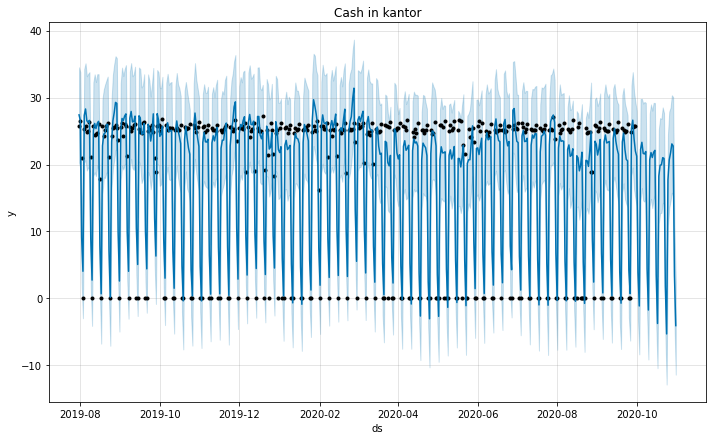

In [95]:
model_cash_in_kantor = Prophet(**best_params, yearly_seasonality= True, holidays = holiday)
model_cash_in_kantor.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_in_kantor.fit(log_cash_in_kantor)

future = model_cash_in_kantor.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_in_kantor.predict(future)

plt.figure(figsize = (17,8))
a = model_cash_in_kantor.plot(forecast)
plt.title('Cash in kantor')

#b = model_cash_in_kantor.plot_components(forecast)

In [96]:
actual_predict_cash_in_kantor_holiday = cash_in_kantor.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_in_kantor_holiday['actual'] = actual_predict_cash_in_kantor_holiday['actual']
actual_predict_cash_in_kantor_holiday['prediction'] = forecast['yhat'].apply(np.exp)
actual_predict_cash_in_kantor_holiday['error (MAE)'] = np.abs(actual_predict_cash_in_kantor_holiday['actual'] - actual_predict_cash_in_kantor_holiday['prediction'])
#actual_predict_cash_in_kantor['MAPE'] = (np.abs(actual_predict_cash_in_kantor['actual'] - actual_predict_cash_in_kantor['prediction'])*100)/actual_predict_cash_in_kantor['actual']
mean_squared_log_error(y_true = np.abs(actual_predict_cash_in_kantor_holiday['actual']),y_pred = np.abs(actual_predict_cash_in_kantor_holiday['prediction'])) ** 0.5

5.533110401584228

In [97]:
actual_predict_cash_in_kantor_holiday.tail(10)

ds        actual    prediction   error (MAE)
418 2020-09-21  8.076297e+10  5.261111e+10  2.815185e+10
419 2020-09-22  6.480904e+10  4.510436e+09  6.029860e+10
420 2020-09-23  7.428744e+10  1.050955e+09  7.323648e+10
421 2020-09-24  1.927066e+11  8.325491e+08  1.918741e+11
422 2020-09-25  0.000000e+00  6.746762e+01  6.746762e+01
423 2020-09-26  0.000000e+00  2.069616e+00  2.069616e+00
424 2020-09-27  6.466720e+10  1.051590e+11  4.049180e+10
425 2020-09-28  1.264345e+11  3.640564e+11  2.376219e+11
426 2020-09-29  1.548627e+11  2.219326e+10  1.326695e+11
427 2020-09-30  1.487817e+11  3.646852e+09  1.451349e+11

In [98]:
predict_cash_in_kantor = list(forecast['yhat'].apply(np.exp).tail(31).values)

#### Cash out kantor

In [99]:
cash_out_kantor = df_train_copy[['periode', 'cash_out_kantor']].rename(columns = {'periode' : 'ds', 'cash_out_kantor' : 'y'})
cash_out_kantor.head()

ds             y
0 2019-07-31 -1.106104e+11
1 2019-08-01 -6.710987e+10
2 2019-08-02 -1.142332e+09
3 2019-08-03  0.000000e+00
4 2019-08-04 -8.729274e+10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash out kantor')

<Figure size 1224x576 with 0 Axes>

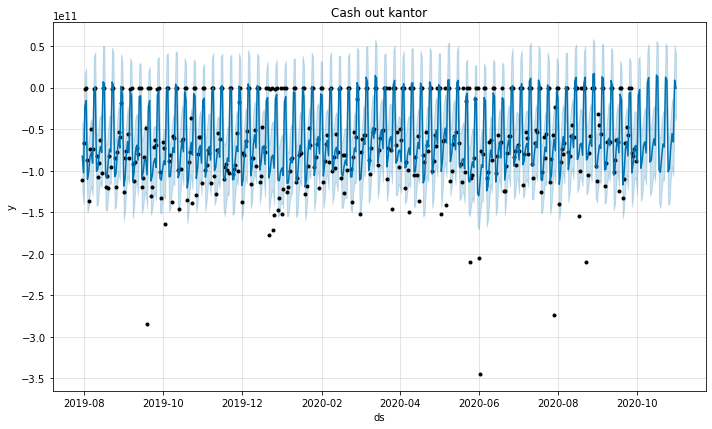

In [100]:
model_cash_out_kantor = Prophet(yearly_seasonality = True, holidays = holiday)
model_cash_out_kantor.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_out_kantor.fit(cash_out_kantor)

future = model_cash_out_kantor.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_out_kantor.predict(future)

plt.figure(figsize = (17,8))
model_cash_out_kantor.plot(forecast)
plt.title('Cash out kantor')

In [101]:
#model_cash_out_kantor.plot_components(forecast)

In [102]:
actual_predict_cash_out_kantor = cash_out_kantor.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_out_kantor['prediction'] = forecast['yhat']
actual_predict_cash_out_kantor['error (MAE)'] = np.abs(actual_predict_cash_out_kantor['actual'] - actual_predict_cash_out_kantor['prediction'])
actual_predict_cash_out_kantor['MAPE'] = (np.abs(actual_predict_cash_out_kantor['actual'] - actual_predict_cash_out_kantor['prediction'])*100)/actual_predict_cash_out_kantor['actual']
actual_predict_cash_out_kantor.head()
mean_squared_log_error(y_true = np.abs(actual_predict_cash_out_kantor['actual']),y_pred = np.abs(actual_predict_cash_out_kantor['prediction'])) ** 0.5

12.022863805772312

Hyperparameter Tunning

In [104]:
from tqdm import tqdm
import itertools

param_grid = {
    'seasonality_mode' : ['multiplicative', 'additive'],
    'changepoint_prior_scale' : [0.001, 0.005, 0.1, 0.2, 0.25, 0.5],
    'changepoint_range' : [0.8, 0.85, 0.9, 0.95]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

for params in tqdm(all_params):
  model = Prophet(**params, yearly_seasonality= True, holidays =holiday)
  model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
  model.fit(cash_in_kantor)
  future_tunning = model.make_future_dataframe(periods = 31, freq = 'D')
  forecast_tunning = model.predict(future_tunning)

  rmlse = mean_squared_log_error(y_true=np.abs(cash_out_kantor['y']), y_pred=np.abs(forecast_tunning['yhat'].head(428))) ** 0.5
  rmsles.append(rmlse)

 73%|███████████████████████████████████████████████████████████▊                      | 35/48 [04:48<01:13,  5.66s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [06:00<00:00,  7.50s/it]


In [105]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by = 'rmsle').head(5)

seasonality_mode  changepoint_prior_scale  changepoint_range      rmsle
9    multiplicative                    0.100               0.85  12.373186
7    multiplicative                    0.005               0.95  12.373497
23   multiplicative                    0.500               0.95  12.385750
10   multiplicative                    0.100               0.90  12.387207
19   multiplicative                    0.250               0.95  12.387816

In [106]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'seasonality_mode': 'multiplicative',
 'changepoint_prior_scale': 0.1,
 'changepoint_range': 0.85}

`Best Model`

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cash out kantor')

<Figure size 1224x576 with 0 Axes>

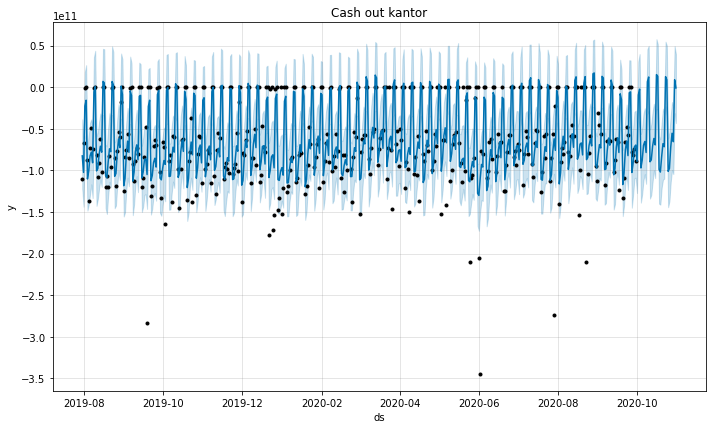

In [107]:
model_cash_out_kantor = Prophet(yearly_seasonality = True, holidays = holiday)
model_cash_out_kantor.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_cash_out_kantor.fit(cash_out_kantor)

future = model_cash_out_kantor.make_future_dataframe(periods = 31, freq = 'D')
forecast = model_cash_out_kantor.predict(future)

plt.figure(figsize = (17,8))
model_cash_out_kantor.plot(forecast)
plt.title('Cash out kantor')

In [108]:
actual_predict_cash_out_kantor = cash_out_kantor.copy().rename(columns = {'y' : 'actual'})
actual_predict_cash_out_kantor['prediction'] = forecast['yhat']
actual_predict_cash_out_kantor['error (MAE)'] = np.abs(actual_predict_cash_out_kantor['actual'] - actual_predict_cash_out_kantor['prediction'])
actual_predict_cash_out_kantor['MAPE'] = (np.abs(actual_predict_cash_out_kantor['actual'] - actual_predict_cash_out_kantor['prediction'])*100)/actual_predict_cash_out_kantor['actual']
actual_predict_cash_out_kantor.head()
mean_squared_log_error(y_true = np.abs(actual_predict_cash_out_kantor['actual']),y_pred = np.abs(actual_predict_cash_out_kantor['prediction'])) ** 0.5

12.022863805772312

In [109]:
predict_cash_out_kantor = list(forecast['yhat'].tail(31).values)

#### Prediction Result for Kas Kantor

In [110]:
init_kantor = df_train_copy['kas_kantor'].tail(1).values[0]
lst_kantor = []
for i in range(31):
  kas_kantor = init_kantor + predict_cash_in_kantor[i] + predict_cash_out_kantor[i]
  lst_kantor.append(kas_kantor)
  init_kantor = lst_kantor[i]
len(lst_kantor)

31

In [111]:
datelist = pd.date_range(start="2020-10-01",end="2020-10-31").tolist()

In [113]:
Kas_kantor_prediction = pd.DataFrame({
    'index' : [i for i in range(31)],
    'date' : datelist,
    'value' : lst_kantor
})

In [114]:
Kas_kantor_prediction

index       date         value
0       0 2020-10-01  1.132115e+13
1       1 2020-10-02  1.131181e+13
2       2 2020-10-03  1.130946e+13
3       3 2020-10-04  1.121708e+13
4       4 2020-10-05  1.114289e+13
5       5 2020-10-06  1.107565e+13
6       6 2020-10-07  1.101278e+13
7       7 2020-10-08  1.093768e+13
8       8 2020-10-09  1.094421e+13
9       9 2020-10-10  1.095644e+13
10     10 2020-10-11  1.086779e+13
11     11 2020-10-12  1.078326e+13
12     12 2020-10-13  1.071359e+13
13     13 2020-10-14  1.065498e+13
14     14 2020-10-15  1.058961e+13
15     15 2020-10-16  1.060472e+13
16     16 2020-10-17  1.061771e+13
17     17 2020-10-18  1.051888e+13
18     18 2020-10-19  1.041733e+13
19     19 2020-10-20  1.033439e+13
20     20 2020-10-21  1.026785e+13
21     21 2020-10-22  1.019751e+13
22     22 2020-10-23  1.021015e+13
23     23 2020-10-24  1.021900e+13
24     24 2020-10-25  1.011788e+13
25     25 2020-10-26  1.002121e+13
26     26 2020-10-27  9.951839e+12
27     27 2020-10-28  9.906982e+12
28     28 2020-10-29  9.849187e+12
29     29 2020-10-30  9.858138e+12
30     30 2020-10-31  9.857273e+12